In [1]:
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

C:\Users\dcdmm\anaconda3\envs\pytorch_env\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
X = datasets.fetch_covtype().data[:3000]
y = datasets.fetch_covtype().target[:3000]
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_va, y_train, y_va = train_test_split(X_1, y_1)

print(X_train.shape, y_train.shape)
print(np.unique(y_train))  # 7分类任务

(2025, 54) (2025,)
[1 2 3 4 5 6 7]


In [3]:
enc = OrdinalEncoder()
y_train_enc = enc.fit_transform(y_train.reshape(-1, 1))
y_test_enc = enc.transform(y_test.reshape(-1, 1))
y_va_enc = enc.fit_transform(y_va.reshape(-1, 1))
print(np.unique(y_train_enc))
print(y_train_enc.shape)

[0. 1. 2. 3. 4. 5. 6.]
(2025, 1)


In [4]:
# label.shape = (num_sample, 1)
train_dataset = xgb.DMatrix(data=X_train, label=y_train_enc)
val_dataset = xgb.DMatrix(data=X_va, label=y_va_enc)
test_dataset = xgb.DMatrix(data=X_test)

In [5]:
params = {'objective': 'multi:softmax',
          "eval_metric": 'mlogloss',
          "verbosity": 0,
          "max_depth": 3,
          'num_class': 7}

# train_dataset的名称为train_,val_dataset的名称定义为val_
eval_set = [(train_dataset, "train_"), (val_dataset, "val_")]
evals_result = {}  # 储存评估指标(内置和自定义)结果

In [6]:
from sklearn.metrics import log_loss


def my_xgb_loss(y_pred, y_true):
    """xgboost自定义验证数据集损失函数格式"""
    loss = log_loss(y_true.get_label(), y_pred)
    return 'MY_GBM_LOSS', loss

In [7]:
model = xgb.train(params=params,
                  dtrain=train_dataset,
                  # num_boost_round (int) – Number of boosting iterations.
                  # 默认num_boost_round=10
                  num_boost_round=200,
                  # List of validation sets for which metrics will evaluated during training.
                  evals=eval_set,
                  early_stopping_rounds=100,
                  # verbose_eval (bool or int) – Requires at least one item in evals.
                  # If verbose_eval is True then the evaluation metric on the validation set is printed at each boosting stage.
                  # If verbose_eval is an integer then the evaluation metric on the validation set is printed at every given verbose_eval boosting stage.
                  # The last boosting stage / the boosting stage found by using
                  verbose_eval=20,  # 默认verbose_eval=True
                  evals_result=evals_result,
                  feval=my_xgb_loss,
                  )

[0]	train_-mlogloss:1.49178	train_-MY_GBM_LOSS:1.35788	val_-mlogloss:1.51103	val_-MY_GBM_LOSS:1.38019
[20]	train_-mlogloss:0.42169	train_-MY_GBM_LOSS:0.69003	val_-mlogloss:0.52481	val_-MY_GBM_LOSS:0.84320
[40]	train_-mlogloss:0.29246	train_-MY_GBM_LOSS:0.58082	val_-mlogloss:0.45119	val_-MY_GBM_LOSS:0.91687
[60]	train_-mlogloss:0.21930	train_-MY_GBM_LOSS:0.51427	val_-mlogloss:0.42108	val_-MY_GBM_LOSS:0.96393
[80]	train_-mlogloss:0.17275	train_-MY_GBM_LOSS:0.46841	val_-mlogloss:0.40679	val_-MY_GBM_LOSS:0.98268
[100]	train_-mlogloss:0.13665	train_-MY_GBM_LOSS:0.43093	val_-mlogloss:0.40146	val_-MY_GBM_LOSS:1.10272
[120]	train_-mlogloss:0.11376	train_-MY_GBM_LOSS:0.40149	val_-mlogloss:0.40424	val_-MY_GBM_LOSS:1.21773
[127]	train_-mlogloss:0.10425	train_-MY_GBM_LOSS:0.39168	val_-mlogloss:0.40560	val_-MY_GBM_LOSS:1.08853


In [8]:
# 预测结果为概率向量(多分类)
# test_dataset:The dmatrix storing the input
model.predict(test_dataset).shape

(300,)

In [9]:
evals_result

{'train_': OrderedDict([('mlogloss',
               [1.491781,
                1.251704,
                1.081855,
                0.958179,
                0.865501,
                0.793492,
                0.738167,
                0.69115,
                0.648161,
                0.612542,
                0.582813,
                0.55971,
                0.533791,
                0.51509,
                0.498563,
                0.481962,
                0.466302,
                0.454549,
                0.44468,
                0.431799,
                0.421691,
                0.412139,
                0.40504,
                0.393888,
                0.386807,
                0.379009,
                0.371349,
                0.365215,
                0.357957,
                0.350532,
                0.345168,
                0.338762,
                0.33318,
                0.328576,
                0.32352,
                0.318211,
                0.313301,
        

In [10]:
evals_result['train_'].keys()

odict_keys(['mlogloss', 'MY_GBM_LOSS'])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

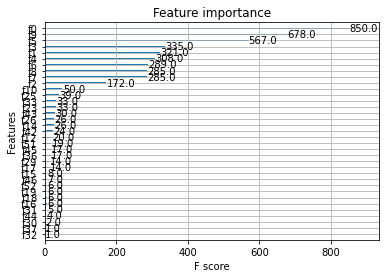

In [11]:
# 绘制特征的相对重要性
xgb.plot_importance(model)

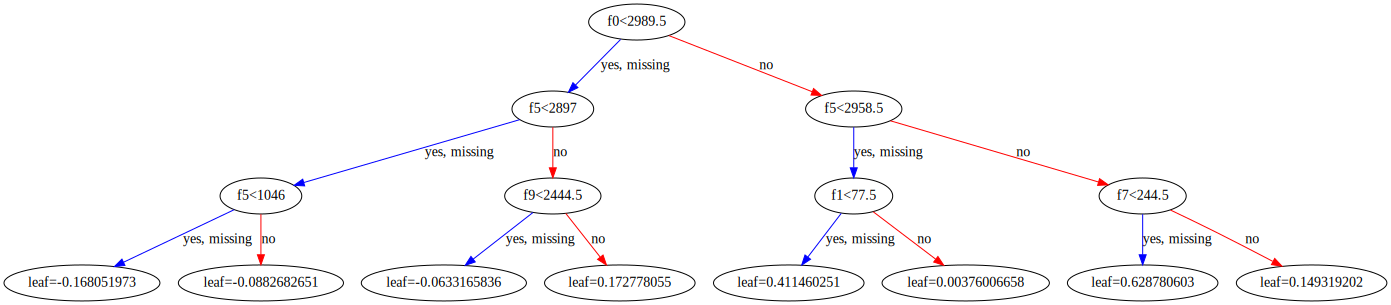

In [12]:
# 可视化lgb分割过程
img = xgb.to_graphviz(model,
                      # 目标函数是所有树的预测值相加等于预测值
                      num_trees=0)
# leaf=-0.15269695
# leaf=0.056757
# leaf=-0.125725
# leaf=-0.160423
# ......
# 表示xgboost论文中的$ \mathcal{L}_split $(决定特征的最佳分裂点)
img

In [13]:
# 数据类型graphviz.files.Source
type(img)

graphviz.sources.Source

In [14]:
# Parse a boosted tree model text dump into a pandas DataFrame structure.
# This feature is only defined when the decision tree model is chosen as base learner (booster in {gbtree, dart}).
df = model.trees_to_dataframe()
df.head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f0,2989.5,0-1,0-2,0-1,327.018066,495.918396,NaN
1,0,1,0-1,f5,2897.0,0-3,0-4,0-3,28.647682,371.755127,NaN
2,0,2,0-2,f5,2958.5,0-5,0-6,0-5,46.484253,124.163277,NaN
3,0,3,0-3,f5,1046.0,0-7,0-8,0-7,4.760910,305.142883,NaN
4,0,4,0-4,f9,2444.5,0-9,0-10,0-9,10.248411,66.612251,NaN


In [15]:
df[df['Tree'] == 0]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f0,2989.5,0-1,0-2,0-1,327.018066,495.918396,NaN
1,0,1,0-1,f5,2897.0,0-3,0-4,0-3,28.647682,371.755127,NaN
2,0,2,0-2,f5,2958.5,0-5,0-6,0-5,46.484253,124.163277,NaN
3,0,3,0-3,f5,1046.0,0-7,0-8,0-7,4.760910,305.142883,NaN
4,0,4,0-4,f9,2444.5,0-9,0-10,0-9,10.248411,66.612251,NaN
5,0,5,0-5,f1,77.5,0-11,0-12,0-11,13.523304,31.836737,NaN
6,0,6,0-6,f7,244.5,0-13,0-14,0-13,26.004334,92.326538,NaN
7,0,7,0-7,Leaf,NaN,NaN,NaN,NaN,-0.168052,196.897980,NaN
8,0,8,0-8,Leaf,NaN,NaN,NaN,NaN,-0.088268,108.244904,NaN
9,0,9,0-9,Leaf,NaN,NaN,NaN,NaN,-0.063317,27.428574,NaN
